# Load and check data

In [1]:
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

/home/guido/.conda/envs/dl/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load in the train and test datasets
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

full_data = [train, test]

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

# preview the data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()
print("----------------------------")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Feature Engineering

In [5]:
# ----- Name -----
# Create a new feature Name_length, containing the length of passenger names
for dataset in full_data:
    dataset['Name_length'] = dataset['Name'].apply(len)


def get_surname(name):
    try:
        return name.split(',')[0]
    except Exception:
        return ""

#print(train['Name'][:10])
#train['Surname'] = train['Name'].apply(get_surname)  # ----------
#print(train['Surname'][:10])

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if (title_search):
        return title_search.group(1)
    return ""


# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace([
        'Capt', 'Col', 'Countess', 'Don', 'Dr', 'Dona', 'Jonkheer', 'Lady',
        'Major', 'Rev', 'Sir'
    ], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [6]:
# ----- Sex ------
# Create a New feature Child
def get_child(passenger):
    age, sex = passenger
    return 'child' if age < 16 else sex


for dataset in full_data:
    dataset['Child'] = dataset[['Age', 'Sex']].apply(get_child, axis=1)
print(train[['Child', 'Survived']].groupby(['Child'], as_index=False).mean())


# Create a New feature Mother
def get_mother(passenger):
    age, sex, parch, title = passenger
    return 'mother' if age > 16 and sex == 'female' and parch > 0 and title != 'Miss' else 'not mother'


for dataset in full_data:
    dataset['Mother'] = dataset[['Age', 'Sex', 'Parch', 'Title']].apply(
        get_mother, axis=1)
print(train[['Mother', 'Survived']].groupby(['Mother'], as_index=False).mean())

    Child  Survived
0   child  0.590361
1  female  0.756458
2    male  0.163873
       Mother  Survived
0      mother  0.716981
1  not mother  0.362768


In [7]:
# ----- Age -----
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(
        age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'], 5)

train[['CategoricalAge', 'Survived']].groupby(
    ['CategoricalAge'], as_index=False).mean()

,CategoricalAge,Survived
0,"(-0.08, 16.0]",0.542857
1,"(16.0, 32.0]",0.360179
2,"(32.0, 48.0]",0.359073
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [8]:
# ----- SibSp and Parch -----
# Create new feature FamilySize as a combination of SibSp and Parch.
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
train['CategoricalFamilySize'] = pd.cut(train['FamilySize'], 3)
print(train[['CategoricalFamilySize', 'Survived']].groupby(
    ['CategoricalFamilySize'], as_index=False).mean())

print(train[['FamilySize', 'Survived']].groupby(
    ['FamilySize'], as_index=False).mean())

# Create new feature IsAlone from FamilySize.
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

  CategoricalFamilySize  Survived
0         (0.99, 4.333]  0.400483
1        (4.333, 7.667]  0.204082
2         (7.667, 11.0]  0.000000
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [9]:
# ----- Fare -----
# Fill all NULLS in the Fare column and create a new feature CategoricalFare.
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean()

,CategoricalFare,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [10]:
# ----- Cabin -----
# Feature that tells whether a passenger had a cabin on the Titanic
for dataset in full_data:
    dataset['Has_Cabin'] = dataset["Cabin"].apply(
        lambda x: 0 if type(x) == float else 1)
print(train[['Has_Cabin', 'Survived']].groupby(['Has_Cabin'], as_index=False).mean())

# Create new feature Deck as deck of a passenger.
def get_deck(cabin):
    try:
        return cabin[0]
    except Exception:
        return ""


for dataset in full_data:
    dataset['Deck'] = dataset['Cabin'].apply(get_deck)

print(train[['Deck', 'Survived']].groupby(['Deck'], as_index=False).mean())

   Has_Cabin  Survived
0          0  0.299854
1          1  0.666667
  Deck  Survived
0       0.299854
1    A  0.466667
2    B  0.744681
3    C  0.593220
4    D  0.757576
5    E  0.750000
6    F  0.615385
7    G  0.500000
8    T  0.000000


In [11]:
# ----- Embarked -----
# Fill all NULLS in the Embarked column.
idx = train['Embarked'].value_counts().index[0]  # 'S'
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna(idx)
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


# Data Cleaning

In [12]:
for dataset in full_data:
    # Mapping Title
    title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    # Mapping Child
    dataset['Child'] = dataset['Child'].map({'child': 0, 'female': 1, 'male': 2}).astype(int)
    
    # Mapping Mother
    dataset['Mother'] = dataset['Mother'].map({'mother': 0, 'not mother': 1}).astype(int)

    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4
    
    # Mapping Family Size
    dataset.loc[dataset['FamilySize'] <= 4.333, 'FamilySize'] = 0
    dataset.loc[(dataset['FamilySize'] > 4.333) & (dataset['FamilySize'] <= 7.667), 'FamilySize'] = 1
    dataset.loc[(dataset['FamilySize'] > 7.667) & (dataset['FamilySize'] <= 11.0), 'FamilySize'] = 2

    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454),
                'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31),
                'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Deck
    dataset['Deck'] = dataset['Deck'].map({
        '': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'T': 8
    }).astype(int)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({
        'S': 0,
        'C': 1,
        'Q': 2
    }).astype(int)

In [13]:
# Feature Selection
#drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']  -------------------, sibsp, parch, surname
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFamilySize', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

# Visualisations

In [14]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_length,Title,Child,Mother,FamilySize,IsAlone,Has_Cabin,Deck
0,0,3,1,1,1,0,0,0,23,1,2,1,0,0,0,0
1,1,1,0,2,1,0,3,1,51,3,1,1,0,0,1,3
2,1,3,0,1,0,0,1,0,22,2,1,1,0,1,0,0
3,1,1,0,2,1,0,3,0,44,3,1,1,0,0,1,3
4,0,3,1,2,0,0,1,0,24,1,2,1,0,1,0,0


## Pearson Correlation Heatmap

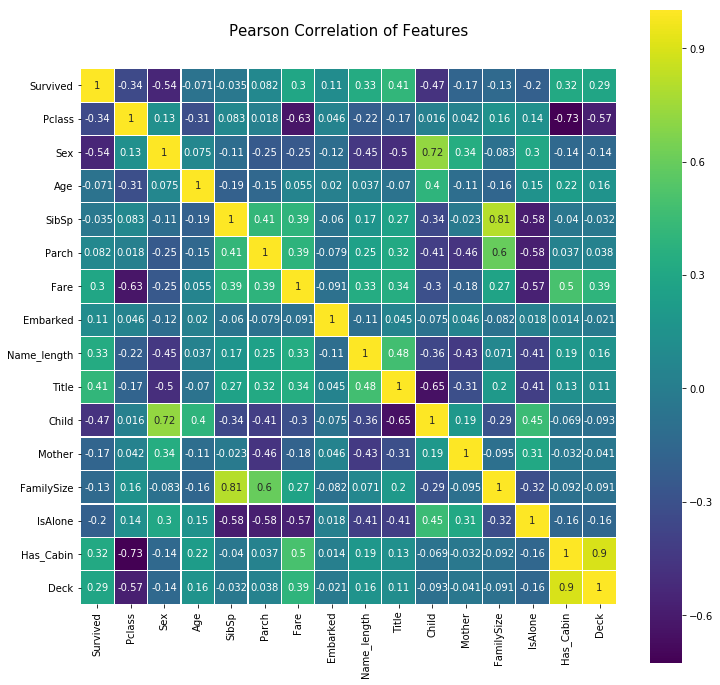

In [15]:
colormap = plt.cm.viridis
plt.figure(figsize=(12, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(
    train.astype(float).corr(),
    linewidths=0.1,
    vmax=1.0,
    square=True,
    cmap=colormap,
    linecolor='white',
    annot=True)

## Pairplots

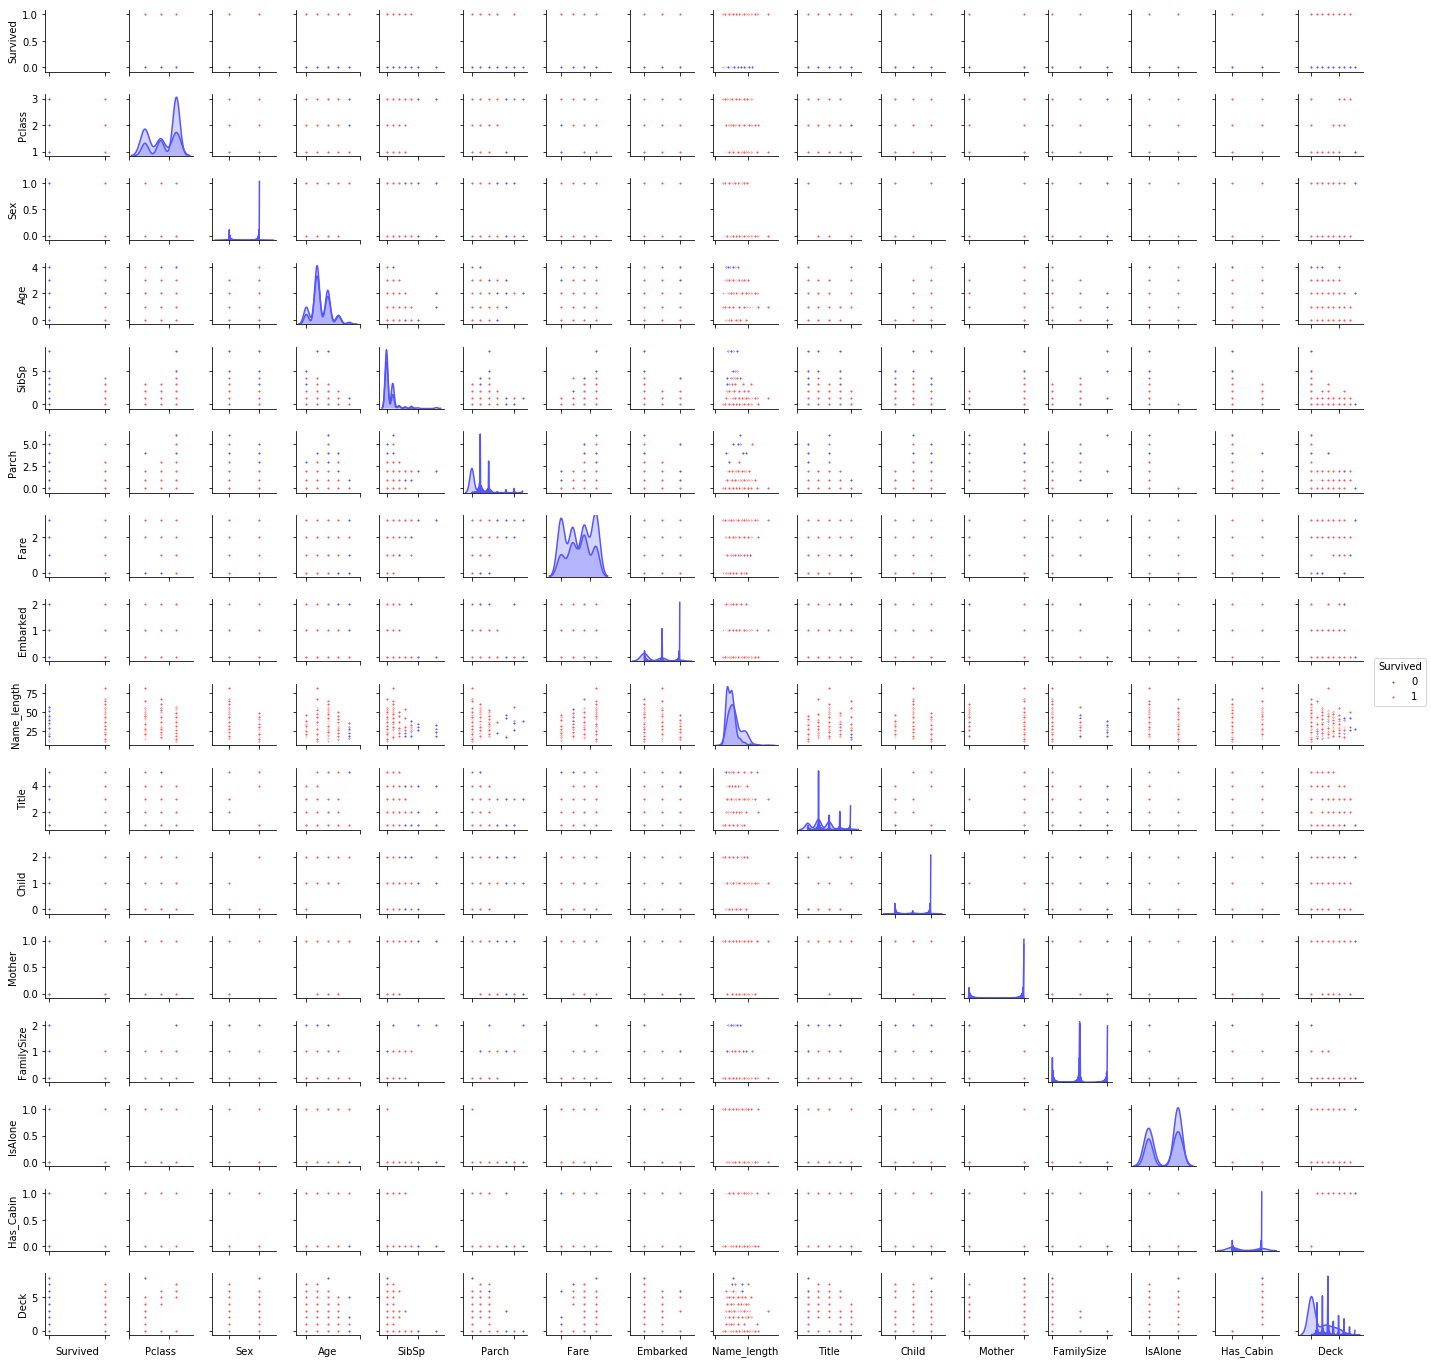

In [16]:
np.seterr(divide='ignore', invalid='ignore')
g = sns.pairplot(
    train[[
        'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Name_length', 'Title', 'Child', 'Mother',
        'FamilySize', 'IsAlone', 'Has_Cabin', 'Deck'
    ]],
    hue='Survived',
    palette='seismic',
    size=1.2,
    diag_kind='kde',
    diag_kws=dict(shade=True),
    plot_kws=dict(s=10))
g.set(xticklabels=[])

# Ensembling & Stacking models

In [17]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0  # for reproducibility
NFOLDS = 5  # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED)


# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x_test):
        return self.clf.predict(x_test)

    def fit(self, x_train, y_train):
        return self.clf.fit(x_train, y_train)

    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_

## Out-of-Fold Predictions

In [18]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models

In [19]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': 1,
    'max_depth': 6,
    'max_features': 'auto',  #
    'min_samples_leaf': 20,  #
    'n_estimators': 300,  #
    'verbose': 0,
    'warm_start': True
}
"""
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}
"""

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {'n_estimators': 500, 'learning_rate': 0.75}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {'kernel': 'linear', 'C': 0.025}

In [20]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

## Creating NumPy arrays out of our train and test sets

In [21]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values  # Creates an array of the train data
x_test = test.values  # Creats an array of the test data

## Output of the First level Predictions

In [22]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print("Training is complete")

/home/guido/.conda/envs/dl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:304: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is complete


## Feature importances generated from the different classifiers

In [23]:
rf_features = rf.feature_importances(x_train, y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train, y_train)
print(rf_features)
print(et_features)
print(ada_features)
print(gb_features)

/home/guido/.conda/envs/dl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:304: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


[ 0.11597303  0.18874035  0.01129987  0.00875781  0.01592041  0.04072347
  0.00959296  0.0522216   0.204901    0.22117045  0.00157619  0.01457515
  0.00822273  0.04630787  0.06001709]
[ 0.10211615  0.26172493  0.01917467  0.02810491  0.01248953  0.04359262
  0.01942817  0.03380415  0.10861424  0.20117058  0.0102624   0.04977716
  0.01541993  0.06158779  0.03273274]
[ 0.038  0.002  0.016  0.016  0.07   0.042  0.01   0.66   0.056  0.004  0.
  0.03   0.006  0.002  0.048]
[ 0.07484597  0.02839658  0.07789707  0.04760419  0.03761309  0.10529188
  0.04227376  0.38447543  0.06970941  0.04839324  0.01124367  0.0079715
  0.02176943  0.00475887  0.03775592]


In [24]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame({
    'features':
    cols,
    'Random Forest feature importances':
    rf_features,
    'Extra Trees  feature importances':
    et_features,
    'AdaBoost feature importances':
    ada_features,
    'Gradient Boost feature importances':
    gb_features
})

## Interactive feature importances via Plotly scatterplots

In [25]:
# Scatter plot
#trace = go.Scatter(
#    y = feature_dataframe['Random Forest feature importances'].values,
#    x = feature_dataframe['features'].values,
#    mode='markers',
#    marker=dict(
#        sizemode = 'diameter',
#        sizeref = 1,
#        size = 25,
##       size= feature_dataframe['AdaBoost feature importances'].values,
#        #color = np.random.randn(500), #set color equal to a variable
#        color = feature_dataframe['Random Forest feature importances'].values,
#        colorscale='Portland',
#        showscale=True
#    ),
#    text = feature_dataframe['features'].values
#)
#data = [trace]

In [26]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head()

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.038,0.102116,0.074846,0.115973,Pclass,0.082734
1,0.002,0.261725,0.028397,0.188740,Sex,0.120215
2,0.016,0.019175,0.077897,0.011300,Age,0.031093
3,0.016,0.028105,0.047604,0.008758,SibSp,0.025117
4,0.070,0.012490,0.037613,0.015920,Parch,0.034006


/home/guido/.conda/envs/dl/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


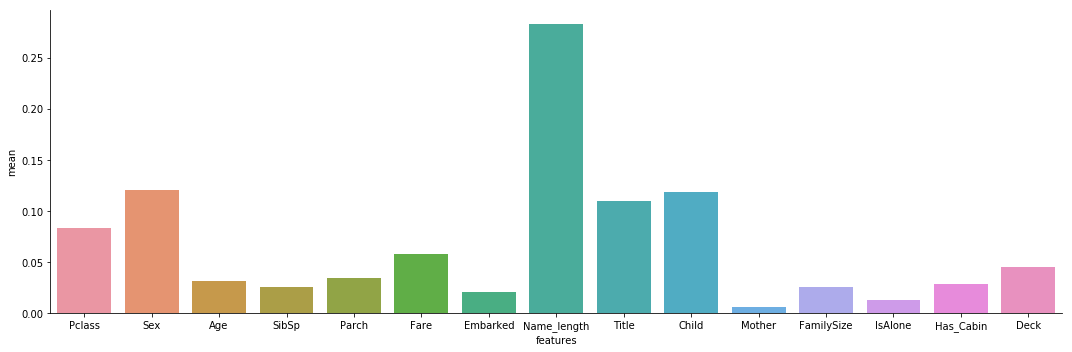

In [27]:
sns.factorplot('features', 'mean', data=feature_dataframe, kind='bar', size=5, aspect=3)

# Second-Level Predictions from the First-level Output

## First-level output as new features

In [28]:
base_predictions_train = pd.DataFrame({
    'RandomForest': rf_oof_train.ravel(),
    'ExtraTrees': et_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
    'GradientBoost': gb_oof_train.ravel()
})
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


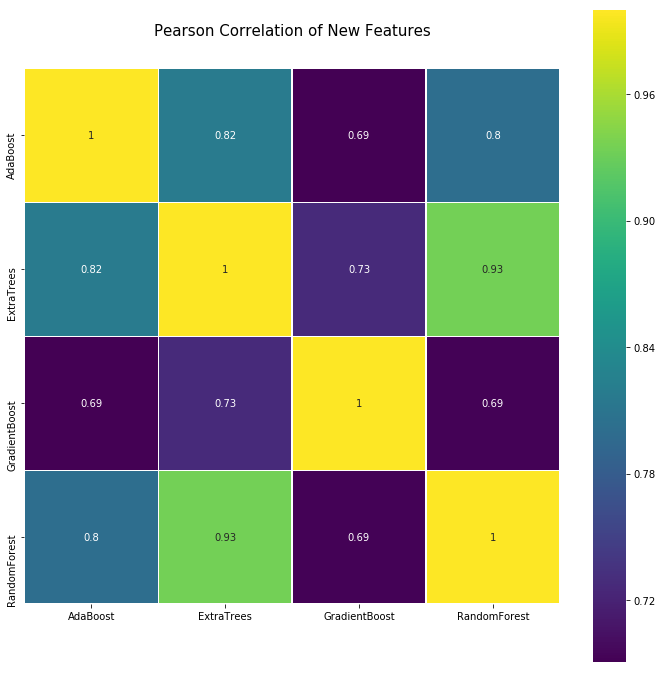

In [29]:
colormap = plt.cm.viridis
plt.figure(figsize=(12, 12))
plt.title('Pearson Correlation of New Features', y=1.05, size=15)
sns.heatmap(
    base_predictions_train.astype(float).corr(),
    linewidths=0.1,
    vmax=1.0,
    square=True,
    cmap=colormap,
    linecolor='white',
    annot=True)

In [30]:
x_train = np.concatenate(
    (rf_oof_train, et_oof_train, ada_oof_train, gb_oof_train, svc_oof_train),
    axis=1)
x_test = np.concatenate(
    (rf_oof_test, et_oof_test, ada_oof_test, gb_oof_test, svc_oof_test),
    axis=1)

## Second level learning model via XGBoost

In [31]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators=2000,
    max_depth=4,
    min_child_weight=2,
    #gamma=1,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

## Producing the Submission file

In [32]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({
    'PassengerId': PassengerId,
    'Survived': predictions
})
StackingSubmission.to_csv("../result/StackingSubmission-20171121-03.csv", index=False)